# Support Vector Machines

## Primal Problem - Linearly Separable Data

We again generate our toy example using multivariate Gaussian distribution.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.stats import multivariate_normal as mvnorm
# Number of classes
c=2 
# Number of elements in each class
n1=100
n2=100
n=n1+n2
color=np.array(np.r_[[0]*n1,[1]*n2])[np.newaxis]
# Ambient dimension
p=2 
########################################################
# Generate randomly two centers and a covariance matrix
datamean=10
m1=np.array([datamean,datamean])
m2=np.array([-datamean,-datamean])
Sigma1 =10*np.eye(p)
Sigma2 = Sigma1
X1=mvnorm.rvs(m1, Sigma1, size=(n1, 1))
X2=mvnorm.rvs(m2, Sigma2, size=(n2, 1))
########################################################
X=np.r_[X1,X2]
Xlabeled=np.r_['1',X,color.T]

The next step is to formulate the quadratic optimization problem. We use cvxopt package to solve the optimization problem.

In [2]:
from cvxopt import matrix
import cvxopt.solvers as solvers
from time import time
########################################################
### Solving the quadratic program
QQP=matrix(np.diag([1]*p+[0]),tc='d')
pQP=matrix([0]*(p+1),tc='d')
yi=2*color-1
GQP=matrix(-1*np.r_['1',np.diag(yi.reshape(n,))@X,yi.T],tc='d')
hQP=matrix([-1]*(n),tc='d')
t0svm = time()
sol=solvers.qp(QQP, pQP, GQP, hQP)
t1svm = time()
w=np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  2.2703e-03  2.0547e+01  4e+02  2e+00  4e+03
 1:  1.6373e-02 -3.2424e+01  4e+01  1e-01  3e+02
 2:  1.9184e-02 -7.5097e-01  8e-01  3e-03  8e+00
 3:  1.8656e-02  4.6204e-03  1e-02  1e-05  2e-02
 4:  1.4261e-02  1.1798e-02  2e-03  2e-06  4e-03
 5:  1.4072e-02  1.3850e-02  2e-04  1e-07  4e-04
 6:  1.4061e-02  1.4059e-02  2e-06  2e-09  4e-06
 7:  1.4061e-02  1.4061e-02  2e-08  2e-11  4e-08
Optimal solution found.


The next step is to find the parameters of the classifier.

In [3]:
###############################
## Ploting the hyperplane
aVec=np.array([w[0],w[1]])
a = -w[0] / w[1]
xx = np.linspace(-20, 20)
yy = a * xx - (w[2]) / w[1]
## Margins
yy_up = a * xx - (w[2]) / w[1]+1/w[1]
yy_down = a * xx - (w[2]) / w[1]-1/w[1]
## Finding the support vectors
upperSV=np.array([X[i] for i in range(n) 
                  if (np.abs(aVec.T@X[i]+w[2]-yi.T[i])<=0.001)])

The output of the classifier is plotted as follows. The support vectors are encircled.

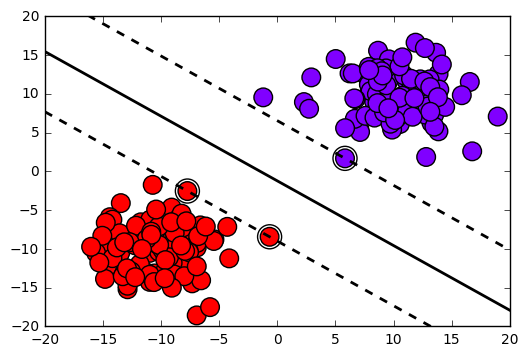

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure()

# plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'k-', linewidth=2)
plt.plot(xx, yy_down, 'k--', linewidth=2)
plt.plot(xx, yy_up, 'k--', linewidth=2)
plt.scatter(upperSV[:, 0], upperSV[:, 1], s=300, facecolors='none')
plt.scatter(X[:,0], X[:,1], s=180, c=color, cmap=plt.cm.rainbow)
plt.axis([-20, 20, -20, 20])
plt.show()


Note that the data is linearly separable. Otherwise the optimization problem would not have any solution.

## Dual Problem- Linearly Separable Data

One can instead solve the dual problem.

In [5]:
########################################################
### Solving the dual program
yi=2*color-1
Qtemp=(yi.T*X)@(yi.T*X).T
QQP=matrix(Qtemp,tc='d')
pQP=matrix([-1]*n,tc='d')
GQP=matrix( -np.eye(n),tc='d')
hQP=matrix([0]*n,tc='d')
AQP=matrix(yi,tc='d')
bQP=matrix([0],tc='d')
t0svmdual=time()
sol=solvers.qp(QQP, pQP, GQP, hQP, AQP, bQP)
t1svmdual=time()
lam=np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -8.6133e+00 -1.4105e+01  4e+02  2e+01  2e+00
 1: -5.5360e+00 -8.1375e-01  4e+01  2e+00  1e-01
 2: -2.3675e-01 -2.0025e-02  8e-01  4e-02  3e-03
 3: -7.5288e-03 -1.8657e-02  1e-02  1e-04  1e-05
 4: -1.2211e-02 -1.4261e-02  2e-03  2e-05  2e-06
 5: -1.3885e-02 -1.4072e-02  2e-04  2e-06  1e-07
 6: -1.4060e-02 -1.4061e-02  2e-06  2e-08  2e-09
 7: -1.4061e-02 -1.4061e-02  2e-08  2e-10  2e-11
Optimal solution found.


In [6]:
####################################
## Finding the paramateres
## supporting normal vector
w=lam.T@(np.diag(yi.reshape(n,))@X)
a = -w[0,0] / w[0,1]
# ## Finding the support vectors
SVs=np.array([Xlabeled[i] for i in range(n)
              if np.abs(lam[i])>0.001])
nSV=len(SVs) # Their numbers
for i in range(1,nSV):
    if SVs[i,-1] != SVs[0,-1]:
        svtemp=(SVs[i]+SVs[0])[0:-1]
        bw=w@svtemp/2
        break
b=bw/w[0,1]
###############################
## Ploting the hyperplane
xx = np.linspace(-20, 20)
yy = a* xx + b
# ## Margins
yy_up = a * xx +b+1/w[0,1]
yy_down = a * xx +b-1/w[0,1]

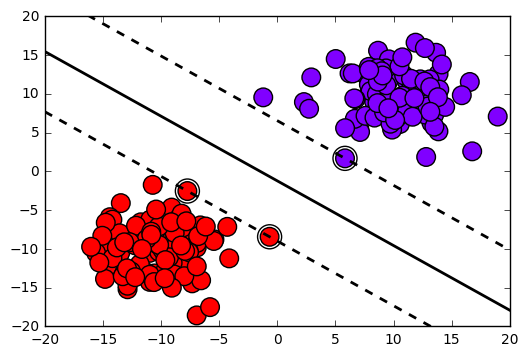

In [7]:
### Just a plot
fig = plt.figure()
# plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'k-', linewidth=2)
plt.plot(xx, yy_down, 'k--', linewidth=2)
plt.plot(xx, yy_up, 'k--', linewidth=2)
plt.scatter(SVs[:, 0], SVs[:, 1], s=300, facecolors='none')
plt.scatter(X[:,0], X[:,1], s=180, c=color, cmap=plt.cm.rainbow)
plt.axis([-20, 20, -20, 20])
plt.show()

### Computational Time

When the data is linearly separable, the dimension of search space for the primal problem is the dimension of data plus one. However the dimension of search space for the primal problem is equal to the number of training samples. Therefore when the dimension of data is much higher than the number of training samples, the dual problem is more efficient to solve. Otherwise the primal problem is the good choice. In this problem, obviously the primal problem is more efficient.

In [8]:
print("Solving time of the primal problem:",t1svm-t0svm)
print("Solving time of the dual problem:",t1svmdual-t0svmdual)

Solving time of the primal problem: 0.004499912261962891
Solving time of the dual problem: 0.026248693466186523


## Primal Problem - Linearly non-separable case

When the data is not linearly separable,  penalty terms are added.  We first generate a new dataset which is not linearly separable.


In [9]:
########################################################
# Generate randomly two centers and a covariance matrix
datamean=4
m1=np.array([datamean,datamean])
m2=np.array([-datamean,-datamean])
Sigma1 =8*np.eye(p)
Sigma2 = Sigma1
X1=mvnorm.rvs(m1, Sigma1, size=(n1, 1))
X2=mvnorm.rvs(m2, Sigma2, size=(n2, 1))
########################################################
X=np.r_[X1,X2]
Xlabeled=np.r_['1',X,color.T]

The primal problem is then solved similar to the previous step.

In [10]:
C=6
QQP=matrix(np.diag([1]*p+[0]*(n+1)),tc='d')
pQP=matrix([0]*(p+1)+[C]*n,tc='d')
yi=2*color-1
Gtemp=np.r_[-1*np.r_['1',np.diag(yi.reshape(n,))@X,yi.T,np.eye(n)],
            np.r_['1',np.zeros((n,p+1)),-np.eye(n)]]
GQP=matrix(Gtemp,tc='d')
hQP=matrix([-1]*(n)+[0]*n,tc='d')
t0svmnsp=time()
sol=solvers.qp(QQP, pQP, GQP, hQP)
t1svmnsp=time()
w=np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -6.4069e+03  4.7754e+03  2e+04  1e+01  5e+01
 1:  2.7276e+02 -6.5443e+02  2e+03  1e+00  6e+00
 2:  6.7859e+01 -1.0565e+02  4e+02  2e-01  9e-01
 3:  4.3185e+01 -1.0310e+01  1e+02  6e-02  2e-01
 4:  3.8345e+01  2.2437e+01  2e+01  8e-03  3e-02
 5:  3.6052e+01  2.8545e+01  9e+00  2e-03  7e-03
 6:  3.1824e+01  3.1641e+01  2e-01  4e-05  1e-04
 7:  3.1706e+01  3.1704e+01  2e-03  4e-07  1e-06
 8:  3.1705e+01  3.1705e+01  2e-05  4e-09  1e-08
Optimal solution found.


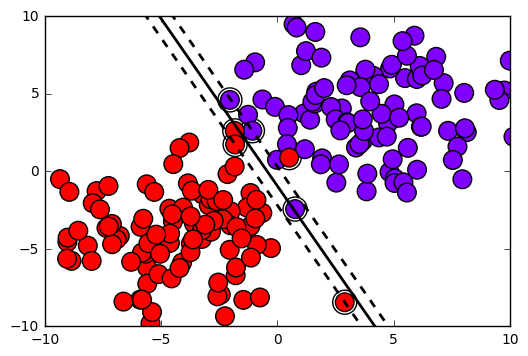

In [11]:
## Ploting the hyperplane
aVec=np.array([w[0],w[1]])
a = -w[0] / w[1]
xx = np.linspace(-20, 20)
yy = a * xx - (w[2]) / w[1]
## Margins
yy_up = a * xx - (w[2]) / w[1]+1/w[1]
yy_down = a * xx - (w[2]) / w[1]-1/w[1]
## Finding the support vectors
upperSV=np.array([X[i] for i in range(n) 
                  if (np.abs(aVec.T@X[i]+w[2]-yi.T[i]*(1-w[i+3]))<=0.001)])
########################################
## Plots
fig = plt.figure()
# plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'k-', linewidth=2)
plt.plot(xx, yy_down, 'k--', linewidth=2)
plt.plot(xx, yy_up, 'k--', linewidth=2)
plt.scatter(upperSV[:, 0], upperSV[:, 1], s=300, facecolors='none')
plt.scatter(X[:,0], X[:,1], s=180, c=color, cmap=plt.cm.rainbow)
plt.axis([-10, 10, -10, 10])

plt.show()


## Dual Problem - Linearly non-separable case

The steps are similar to above. We just run the dual problem accordingly.

In [12]:
C=6
yi=2*color-1
Qtemp=(yi.T*X)@(yi.T*X).T
QQP=matrix(Qtemp,tc='d')
pQP=matrix([-1]*n,tc='d')
GQP=matrix( np.r_[np.eye(n),-np.eye(n)],tc='d')
hQP=matrix([C]*n+[0]*n,tc='d')
AQP=matrix(yi,tc='d')
bQP=matrix([0],tc='d')
t0svmdualnsp=time()
sol=solvers.qp(QQP, pQP, GQP, hQP, AQP, bQP)
t1svmdualnsp=time()
lam=np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -1.3162e+02 -5.4369e+03  2e+04  9e-01  3e-13
 1: -7.7440e+01 -1.5334e+03  2e+03  1e-01  2e-13
 2: -3.5954e+01 -2.6755e+02  4e+02  2e-02  1e-13
 3: -2.8022e+01 -9.6883e+01  1e+02  4e-03  4e-14
 4: -2.7007e+01 -4.5366e+01  2e+01  5e-04  4e-14
 5: -2.9611e+01 -3.7630e+01  9e+00  1e-04  6e-14
 6: -3.1660e+01 -3.1854e+01  2e-01  2e-06  6e-14
 7: -3.1705e+01 -3.1707e+01  2e-03  2e-08  7e-14
 8: -3.1705e+01 -3.1705e+01  2e-05  2e-10  7e-14
Optimal solution found.


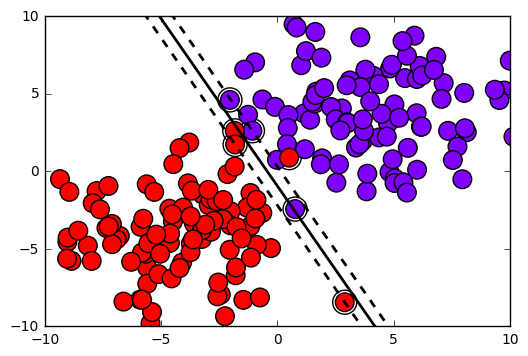

In [13]:
####################################
## Finding the paramateres
## supporting normal vector
w=lam.T@(np.diag(yi.reshape(n,))@X)
a = -w[0,0] / w[0,1]
# ## Finding the support vectors
SVs=np.array([Xlabeled[i] for i in range(n) if np.abs(lam[i])>0.001])
SVmargin=np.array([Xlabeled[i] for i in range(n) 
                   if (C-0.001>np.abs(lam[i])>0.001)])
bnonscaled=-w@SVmargin[0,0:-1]+2*SVmargin[0,-1]-1
b=-bnonscaled/w[0,1]

xx = np.linspace(-20, 20)
yy = a* xx + b
# ## Margins
yy_up = a * xx +b+1/w[0,1]
yy_down = a * xx +b-1/w[0,1]
#####################################################################
#####################################################################
# Plot
#####################################################################
#####################################################################
### Just a plot
fig = plt.figure()

# plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'k-', linewidth=2)
plt.plot(xx, yy_down, 'k--', linewidth=2)
plt.plot(xx, yy_up, 'k--', linewidth=2)
plt.scatter(SVs[:, 0], SVs[:, 1], s=300, facecolors='none')
plt.scatter(X[:,0], X[:,1], s=180, c=color, cmap=plt.cm.rainbow)
plt.axis([-10, 10, -10, 10])
plt.show()


### Computational Time

In case of non-separable data, the dimension of search space is equal to $n+p+1$ where $n$ is the number of samples and $p$ is the data dimension. For the dual problem however, the dimension of search space remains unchanged equal to $n$. Therefore it is in general more efficient to solve the dual problem in this case.  

In [14]:
print("Solving time of the primal problem:",t1svmnsp-t0svmnsp)
print("Solving time of the dual problem:",t1svmdualnsp-t0svmdualnsp)

Solving time of the primal problem: 0.047567129135131836
Solving time of the dual problem: 0.053134918212890625


## Kernel-Based Methods

We use the built-in kernel implementation of python. We first load the model and fit it to the data.

In [15]:
from sklearn import svm
kern='rbf'
t0svmkernel=time()
if (kern=='poly'):
	kernelsvm =svm.SVC(kernel='poly', degree=2,
                       gamma=0.2, coef0=0.1).fit(X, color.T)
elif (kern=='rbf'):
	kernelsvm =svm.SVC(kernel='rbf', gamma=0.4).fit(X, color.T)
t1svmkernel=time()

Afterwards, we plot the figures. 

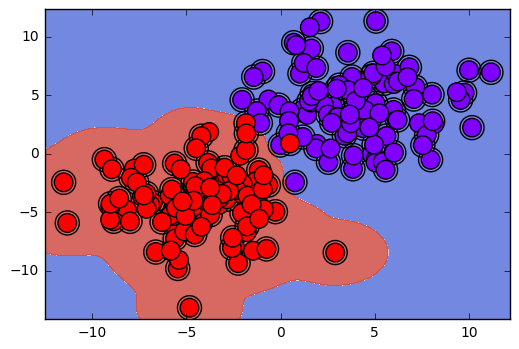

In [16]:
fig = plt.figure()
h = 0.02  
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))                
Z = kernelsvm.predict(np.c_[xx.ravel(), yy.ravel()])                     

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(kernelsvm.support_vectors_[:, 0], 
            kernelsvm.support_vectors_[:, 1], s=300, facecolors='none')
#####################################################################
plt.scatter(X[:,0], X[:,1], s=180, c=color, cmap=plt.cm.rainbow)
plt.axis([x_min, x_max, y_min, y_max])
plt.show()


Note that the computational complexity of the kernel based methods is similar to the dual problem.

## SVM Method for MNIST classification

We first load the dataset using the tensorflow backend.

In [17]:
import tensorflow as tf 
from tensorflow.examples.tutorials.mnist import input_data 
data = input_data.read_data_sets("tensorboard_MNIST/MNIST_data/"
                                 , one_hot=False) 
## Training set
N=55000
Xtraining = data.train.images[0:N]
#Ytraining = data.train.labels[0:N].argmax(axis=1)
Ytraining = data.train.labels[0:N]
## Test set
Ntest=10000
Xtest=data.test.images[0:Ntest]
#Ytest=data.test.labels[0:Ntest].argmax(axis=1)
Ytest=data.test.labels[0:Ntest]

Extracting tensorboard_MNIST/MNIST_data/train-images-idx3-ubyte.gz
Extracting tensorboard_MNIST/MNIST_data/train-labels-idx1-ubyte.gz
Extracting tensorboard_MNIST/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting tensorboard_MNIST/MNIST_data/t10k-labels-idx1-ubyte.gz


Two classification problem is considered:

* Two-class classification problem
* Classification of the whole MNIST dataset

We first start by linear SVM and using two-class classifciation problem.

In [18]:
###############################################################
###############################################################
#### Two classes are chosen accordingly from the training set
Ci=2
Cj=9
## Choosing respective classes from the training set
Ind12=np.array([ind for ind in range(N) if ((Ytraining[ind]==Ci) 
                                            or (Ytraining[ind]==Cj))])
X12=Xtraining[Ind12]
Y12=Ytraining[Ind12]
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("The size of the trainging set with two classes is given by:", len(Ind12))
N12=len(Ind12)
## Choosing respective classes from the test set
Ind12=np.array([ind for ind in range(Ntest) if ((Ytest[ind]==Ci) 
                                                or (Ytest[ind]==Cj))])
Xtest12=Xtest[Ind12]
Ytest12=Ytest[Ind12]
print("The size of the test set with two classes is given by:", len(Ind12))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
N12test=len(Ind12)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The size of the trainging set with two classes is given by: 10924
The size of the test set with two classes is given by: 2041
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [19]:
model = svm.LinearSVC()
model.fit(X12, Y12)
TrainingError=np.count_nonzero(np.array(model.predict(X12))-Y12)/N12
TestError=np.count_nonzero(np.array(model.predict(Xtest12))-Ytest12)/N12test
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("The misclassification error for the training set is given by:",TrainingError)
print("The misclassification error for the test set is given by:",TestError)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The misclassification error for the training set is given by: 0.0009154155986818016
The misclassification error for the test set is given by: 0.014698677119059285
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [20]:
model = svm.LinearSVC()
t0svmmnist=time()
model.fit(Xtraining, Ytraining) 
t1svmmnist=time()
### Training error and Test error
TrainingError=np.count_nonzero(np.array(model.predict(Xtraining))-Ytraining)/N
TestError=np.count_nonzero(np.array(model.predict(Xtest))-Ytest)/Ntest
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("The misclassification error for the training set is given by:",TrainingError)
print("The misclassification error for the test set is given by:",TestError)
print("The training time is:",t1svmmnist-t0svmmnist)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
The misclassification error for the training set is given by: 0.07327272727272727
The misclassification error for the test set is given by: 0.0825
The training time is: 75.13603711128235
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Linear SVM provides a strictly better classification error compared to Fisher LDA.